In [1]:
import math
import numpy as np
from qiskit import *
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit import IBMQ
import matplotlib
%matplotlib inline

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
def loadQuantumImage(path):
    from PIL import Image
    image= Image.open(path)
    (width, height) = image.size
    pixels = image.load()

    ssum = 0
    for i in range(height):
        for j in range(width):
            ssum += pixels[i,j]**2

    m = math.floor(math.log(height, 2))
    n = math.floor(math.log(width, 2))
    stateVector = np.zeros(2**(m+n))
    for i in range(height):
        for j in range(width):
            stateVector[i*width + j] = pixels[i,j]/math.sqrt(ssum)
            
    return stateVector, m, n

In [3]:
def exportQuantumImage(counts, shots, height, width):
    from PIL import Image

    r = math.floor(math.log(height, 2))
    im= Image.new("L", (width, height))
    pixels = im.load()

    maxAmplitude = 256
    medAmplitude = maxAmplitude/2
    med = shots/(height * width)
    for key in counts:
        i = int(key[0:r], 2)
        j = int(key[r:], 2)
        val = round((((counts[key] - med)/med)*medAmplitude) + medAmplitude)
        pixels[i,j] = (val)
        
    return im

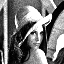

In [7]:
stateVector, m, n = loadQuantumImage('Lena64.png')

circ = QuantumCircuit(m+n, m+n)
indexes = range(m+n)

state = [complex(x) for x in stateVector]
circ.initialize(state, indexes)
circ.measure(indexes, indexes)

provider = IBMQ.get_provider(group='open')
localSimulator = Aer.get_backend('qasm_simulator')
backend = provider.get_backend('ibmq_qasm_simulator')

#2**(m+n)*10
shots = 2**(m+n)*100 # 8190
result = execute(circ, localSimulator, shots=shots).result()
counts = result.get_counts(circ)

exportedImg = exportQuantumImage(counts, shots, 2**m, 2**n)
exportedImg